In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from dataset import Dataset, to_device
from model import ResNet28
from time import time
from tqdm.notebook import tqdm
import json
import pickle

# Load Model and Predict Methods

In [2]:
def load_model_only(config):
    path = config.get('model_path', '')
    f = f"{path}/{config['model_identifier']}.pth"
    print("Loading existing model")
    checkpoint = torch.load(f)
    net = checkpoint['net']
    mean_losses = checkpoint['mean_losses']
    return net, mean_losses

def predict(model, X, y, device='cpu'):
    pyt_device = torch.device(device)

    if 'cuda' in device:
        # Since it doesn't all fit on the GPU, we'll use a dataloader
        batch_size = 2000
        predictDataset = Dataset(X, y)
        predictLoader = torch.utils.data.DataLoader(dataset=predictDataset,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=5,
                                                  pin_memory=True
                                                 )
        num_elements = len(predictLoader.dataset)
        num_outputs = len(y.columns)
        num_batches = len(predictLoader)
        predictions = torch.zeros(num_elements, num_outputs)
        for i, (inputs, _) in tqdm(enumerate(predictLoader), total=num_batches):
            inputs = to_device(inputs, pyt_device)
            start = i*batch_size
            end = start + batch_size
            if i == num_batches - 1:
                end = num_elements
            pred = torch.round(torch.sigmoid(model(inputs)))
            predictions[start:end] = pred.detach().cpu()
        nn_results = predictions.numpy()
    else:
        if type(X) == np.ndarray:
            X_tensor = torch.from_numpy(X).float()
        else:
            X_tensor = torch.from_numpy(X.to_numpy()).float()
        nn_results = torch.round(torch.sigmoid(model(X_tensor))).detach().numpy()

    return nn_results

# Load and Clean Data

In [3]:
def train_test_split(X, y, train_idx=None, test_idx=None):
    X_train = X.loc[train_idx]
    y_train = y.loc[train_idx]
    X_test = X.loc[test_idx]
    y_test = y.loc[test_idx]
    return (X_train, y_train, X_test, y_test)

def load_split_data(suffix=None, split=False):
    if suffix==None:
        suffix='DEFAULT'
        
    X = pd.read_pickle(f'../data/X_{suffix}.pkl')
    y = pd.read_pickle(f'../data/y_{suffix}.pkl')
        
    if split:
        X_train, y_train, X_test, y_test = train_test_split(X, y, X.loc[:'2019'].index, X.loc['2020':].index)
        return X_train, y_train, X_test, y_test
    else:
        return X, y
    
X_train, y_train, X_test, y_test = load_split_data(suffix='20210726', split=True)

# Load Model and Run Predictions

In [4]:
model_id = 'alpha2'

with open(f'models/{model_id}.cfg') as f:
    config = json.load(f)

In [5]:
model, mean_losses = load_model_only(config)

Loading existing model


In [6]:
ss = pickle.load(open(f'models/{model_id}_ss.pkl', 'rb'))

In [7]:
X_test = ss.transform(X_test)

In [8]:
results = predict(model, X_test, y_test, device=config['device'])

  0%|          | 0/28 [00:00<?, ?it/s]

# Analaze Results

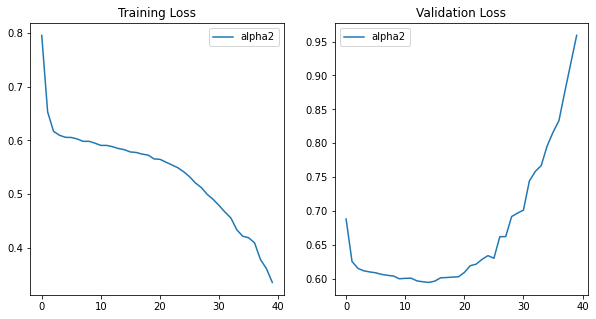

In [12]:
import matplotlib.pyplot as plt

tl, vl = zip(*mean_losses)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.set_title("Training Loss")
ax2.set_title("Validation Loss")
ax1.plot(tl[:40], label=model_id)
ax2.plot(vl[:40], label=model_id)
# ax1.set_yscale('log')
# ax2.set_yscale('log')
ax1.legend()
ax2.legend()
plt.show()

In [10]:
pred = pd.DataFrame(data=results, columns=['pred'])
pred.fillna(1, inplace=True)

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score

print(f'Precision = {round(precision_score(y_test, pred),4)}')
print(f'Recall = {round(recall_score(y_test, pred),4)}')
print(f'F1-Score = {round(f1_score(y_test, pred),4)}')

Precision = 0.3444
Recall = 0.3237
F1-Score = 0.3338
